In [11]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [12]:
db = 'нефть-brent 2010-2019.xlsx'
# df = pd.read_excel(db, index_col=['Дата'], parse_dates=['Дата'], dayfirst=True)
df = pd.read_excel(db)
df.set_index('Дата', inplace = True)
df

,Значение
Дата,
2019-09-01,58.84
2019-08-30,59.19
2019-08-29,60.37
2019-08-28,59.84
2019-08-27,59.59
...,...
2010-09-05,76.63
2010-09-04,76.62
2010-09-03,76.57


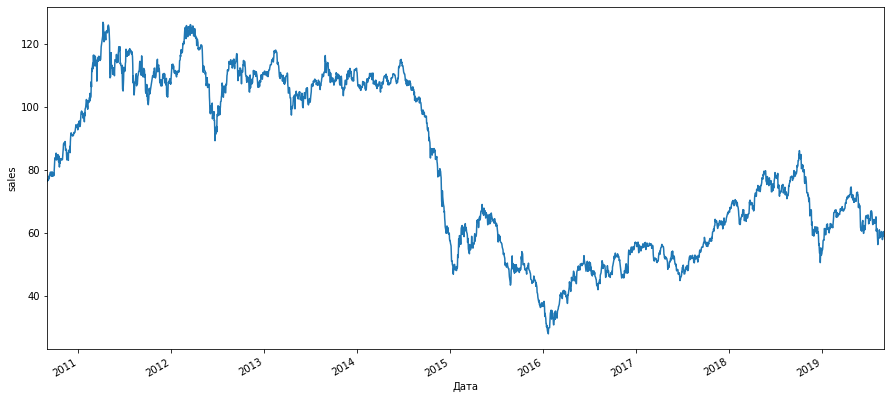

In [13]:
plt.figure(figsize(15,7))
df['Значение'].plot()
plt.ylabel('sales')
pylab.show()

Проверка стационарности и STL-декомпозиция р¤да:

 Критерий Дики-Фуллера: p=0.635186


<Figure size 1080x720 with 0 Axes>

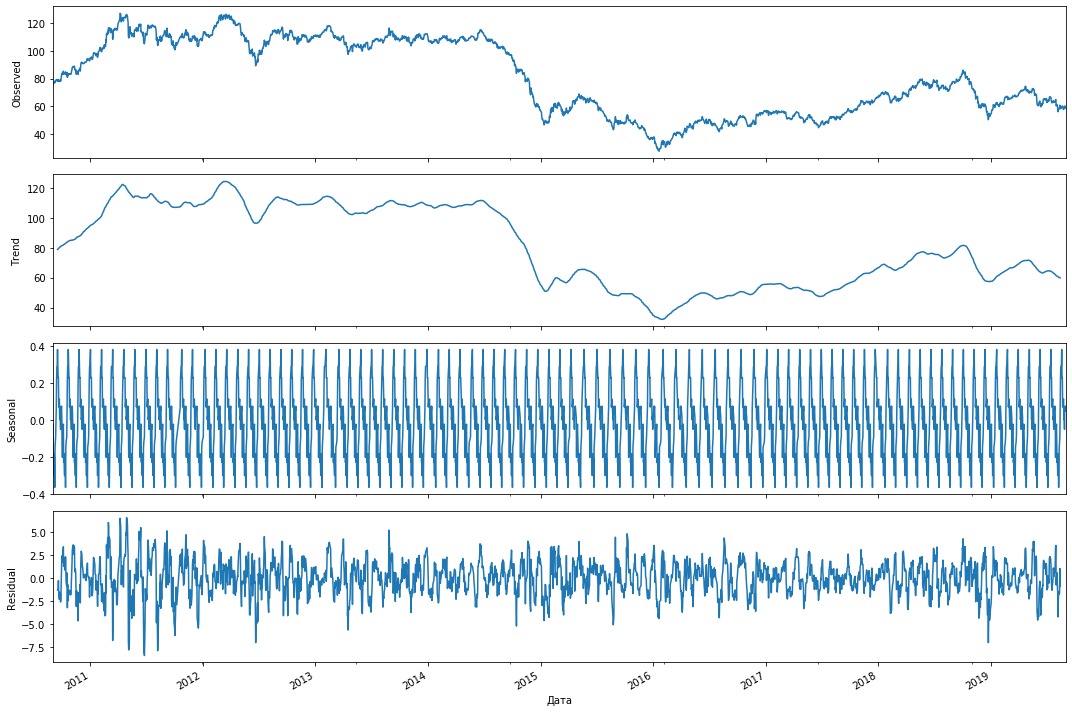

In [14]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df['Значение'], freq = 30).plot()
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Значение'])[1])

—Стабилизация дисперсии

—делаем преобразование Кокса- бокса для стабилизации дисперсии:

Оптимальный параметр преобразования Кокса- Бокса: 0.673894
 Критерий Дики-Фуллера: p=0.640408


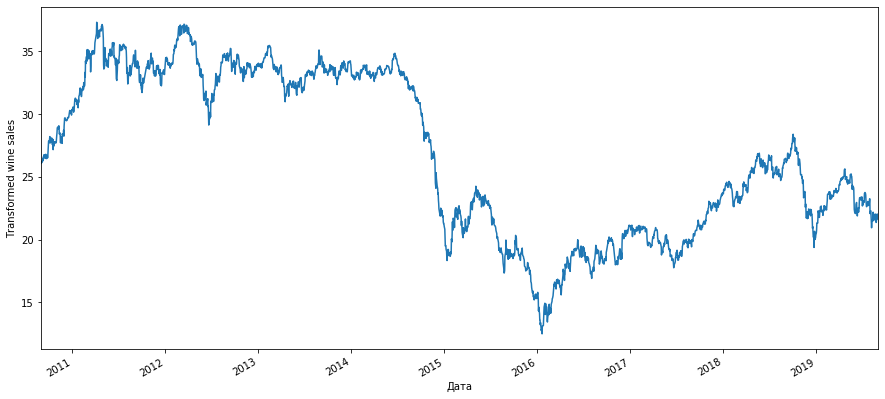

In [15]:
df['Трансформация'], lmbda = stats.boxcox(df['Значение'])
plt.figure(figsize(15,7))
df['Трансформация'].plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Кокса- Бокса: %f" % lmbda)
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Трансформация'])[1])


### —Стационарность
 
 Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

 Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

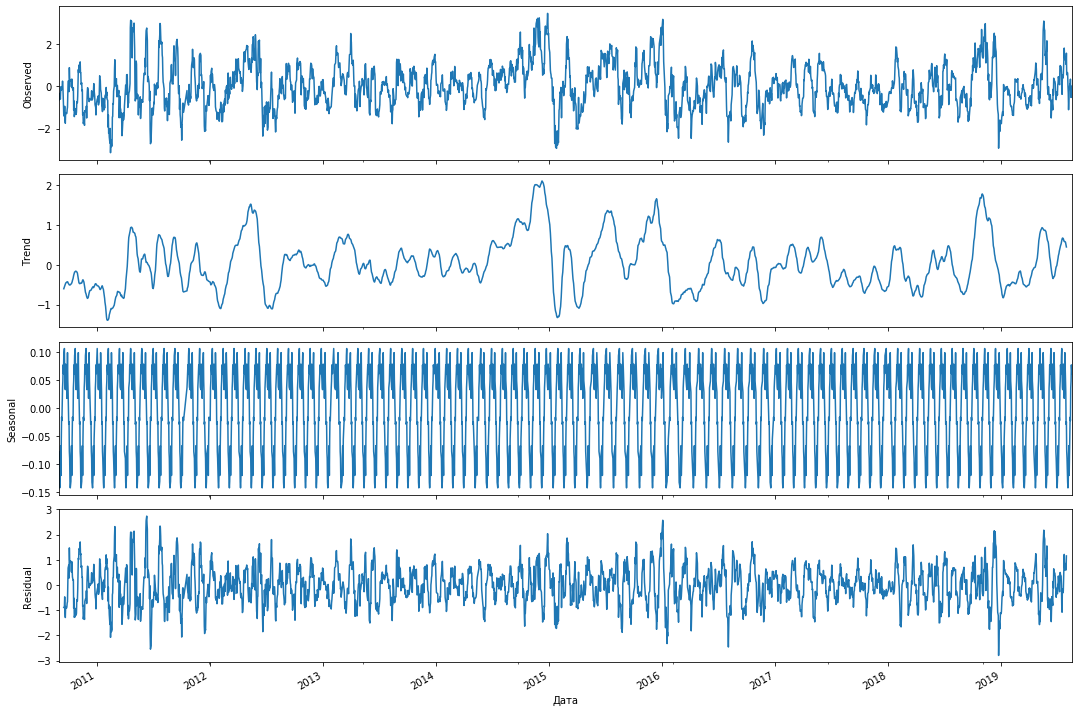

In [16]:
df['Трансформация_2'] = df['Трансформация'] - df['Трансформация'].shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df['Трансформация_2'][12:], freq = 30).plot()
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Трансформация_2'][12:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше тренда больше нет.

### Подбор модели

Посмотрим на ACF и PACF полученного ряда:

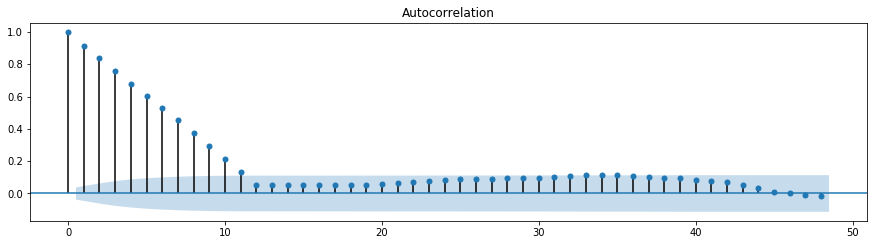

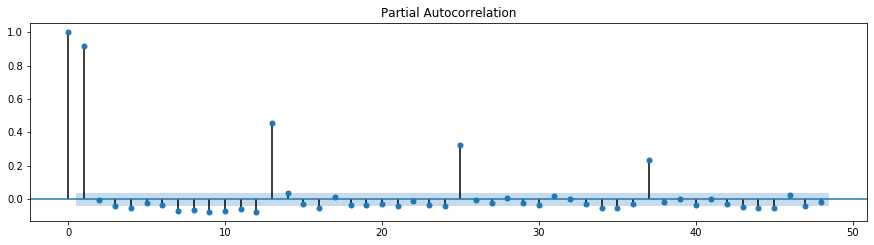

In [17]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['Трансформация_2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df['Трансформация_2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближений: Q=1, q=2, P=1, p=4

In [18]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [19]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [20]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучаетс¤
    try:
        model=sm.tsa.statespace.SARIMAX(df['Трансформация'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохран¤ем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 13min 37s


In [21]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
13  (1, 0, 0, 1)  1145.188410
5   (0, 1, 0, 1)  1145.371006
29  (2, 1, 0, 1)  1145.813651
15  (1, 0, 1, 1)  1145.831184
7   (0, 1, 1, 1)  1145.994957


In [22]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                      Трансформация   No. Observations:                 2667
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -569.594
Date:                            Tue, 03 Mar 2020   AIC                           1145.188
Time:                                    22:03:25   BIC                           1162.840
Sample:                                         0   HQIC                          1151.577
                                           - 2667                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0652      0.016     -3.998      0.000      -0.097      -0.033
ma.S.L12      -0.9931      0.007   

 Критерий —Стьюдента: p=0.556067
 Критерий Дики-Фуллера: p=0.000000


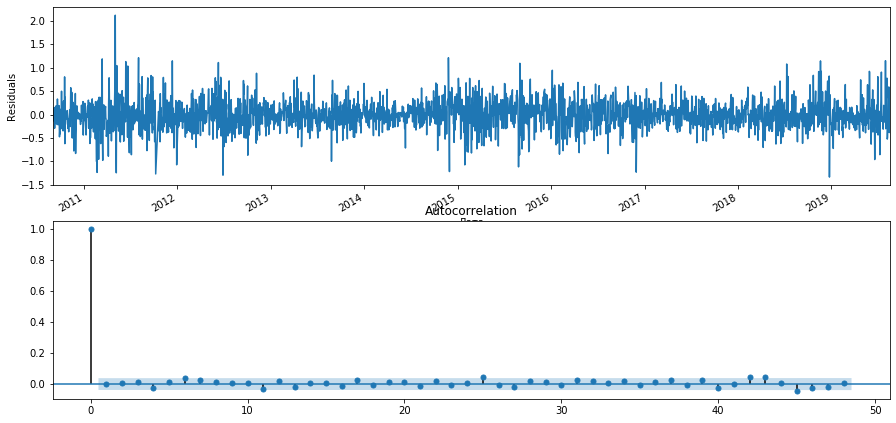

In [23]:

plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print(" Критерий —Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])


Остатки несмещены (подтверждается критерием —Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Тьюнга-Кокса и коррелограммой). ѕосмотрим, насколько хорошо модель описывает данные:

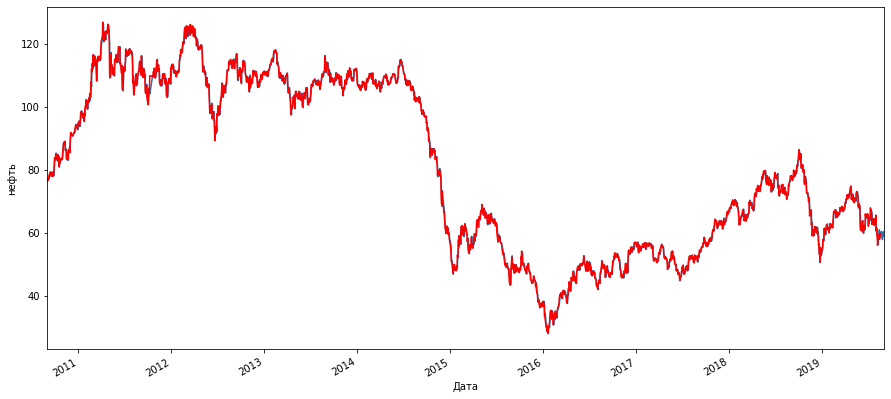

In [24]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df['Значение'].plot()
df.model[13:].plot(color='r')
plt.ylabel('нефть')
pylab.show()

<Figure size 720x504 with 0 Axes>

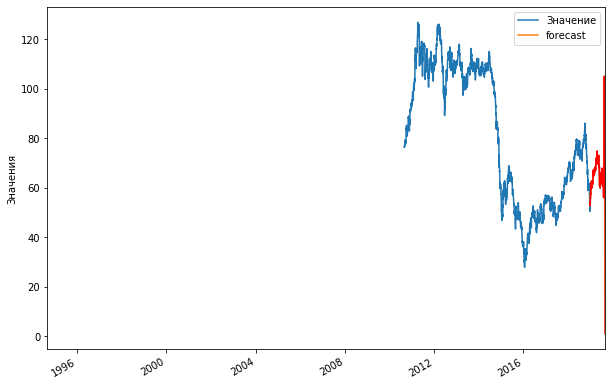

In [30]:

df2 = df[['Значение']]
date_list = [datetime.datetime.strptime("1994-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=0, end=211), lmbda)

plt.figure(figsize(15,7))
df2.plot()
df2.forecast.plot(color='r')
plt.ylabel('Значения')
pylab.show()